In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle


# import source library with classes und functions
import src_hjbnn as src

# Parameters

In [2]:
# set random seed for result reproducibility
dtype = 'float32'
tf.keras.backend.set_floatx(dtype)
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)


# problem parameters: the limits of the considered state space, the constants
# for loss weighting in array form [c_1, c_2, c_3] where normalization can be
# set in the trainer class as well as the number of training samples,
# dt for trajectory calculation in Koopman loss
limits = np.array([[-2, 2]]*32)
loss_weights = np.array([0.1, 0.9, 0.001])
n_samples = 5000
dt = 0.001


# model parameters: activation function, normalization range, initializer,
# pretrain on for Bellcurve, network depth and network width
model_activation = src.Bellcurve(0.5)
model_normalize = 1
model_initializer = tf.keras.initializers.Orthogonal()
model_pretrain = 1
model_depth = 3
model_width = len(limits)


# maximum policy iteration steps
max_iter = 3

# Program

In [3]:
# combine hyperparameters to initializer list
initializer = [model_width, model_depth, model_normalize, model_initializer,
               limits, model_activation, dtype]


# get environment (dynamics) and create control case
env, case = src.setup_from_files(A = 'mat_A.npy',
                                 B = 'mat_B.npy',
                                 Q = 'mat_Q.npy',
                                 R = 'mat_R.npy',
                                 rhs = lambda x: tf.pow(x, 3.),
                                 rhs_np = lambda x: np.pow(x, 3.),
                                 dtype = dtype)


# set Riccati feedback, this will be used as initial coniditon for the discrete
# policy iteration algorithm
env.set_feedback_linear(case.K)
controller = env.feedback


# create monte carlo training and test samples
X_train = src.random_states(limits, n_samples)
X_test = src.random_states(limits, n_samples)


# create neural network model class
model_class = src.MLP
model = model_class(*initializer)
model.summary()


# policy iteration
for i in range(max_iter):

    print('\n\n\nPOLICY ITERATION {}/{}\n\n\n\n'.format(i+1, max_iter))
    controller, v = src.pi_step(case, controller, model_class, initializer,
                                loss_weights, model_pretrain, X_train, X_test,
                                trans_dt=dt)

feedback set: [[0.06473397 0.12967229 0.13028686 0.13131617 0.1327679  0.13465281
  0.13698494 0.1397817  0.14306405 0.14685668 0.15118825 0.15474904
  0.15756597 0.15966034 0.1610479  0.16173908 0.16173908 0.1610479
  0.15966034 0.15756597 0.15474904 0.15118825 0.14685668 0.14306405
  0.1397817  0.13698494 0.13465281 0.1327679  0.13131617 0.13028686
  0.12967229 0.06473397]]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
normalizer (Normalizer)      (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
lambda (Lambda)              (None, 32)                0         
____________

# ANALYSIS ON Sp AND Sp*

In [13]:
# test sample set Sp with 2000 polynomial states
test_filename = 'Sp.samples'
dataset = pickle.load(open(test_filename,'rb'))

# calculate costs for Sp controlled with pi feedback model
env.set_feedback(controller)
_, COSTS_pi = case.transport_states(dataset['X0'], dt=dt, k=int(5/dt))

# difference to optimal costs for k first (most expensive) states
k = 100
D_pi = (COSTS_pi[:k].flatten() - dataset['costs'][:k])/dataset['costs'][:k]
D_ricc = (dataset['costs_riccati'][:k] - dataset['costs'][:k])/dataset['costs'][:k]

# stability
S_pi = (len(COSTS_pi) - np.sum(np.isnan(COSTS_pi)))/len(COSTS_pi)
S_ricc = (len(dataset['costs_riccati']) - np.sum(np.isnan(dataset['costs_riccati'])))/len(dataset['costs_riccati'])

feedback set: <function InfiniteHorizon.feedback_from_value.<locals>.feedback at 0x000001CB9851FCA0>
transporting 2000 samples with assigned feedback control, done in 37.25264835357666 s


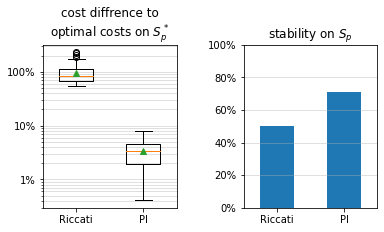

In [17]:
#plot
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].set_title('cost diffrence to\n' + r'optimal costs on $S_p^*$')
axes[0].boxplot([D_ricc, D_pi], widths=0.5, showmeans=True)
axes[0].set_yscale('log')
axes[0].set_xticklabels(['Riccati','PI'])
axes[0].set_xlim([0.5, 2.5])
axes[0].grid(axis='y', which='both', alpha=0.5)
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].set_title(r'stability on $S_p$')
axes[1].bar([1,2], [S_ricc*100, S_pi*100], width=0.5)
axes[1].set_xticks([1,2])
axes[1].set_xticklabels(['Riccati','PI'])
axes[1].set_ylim([0,100])
axes[1].grid(axis='y', alpha=0.5)
axes[1].set_xlim([0.5, 2.5])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/100))) 
plt.subplots_adjust(wspace=0.5)
plt.show()

# ANALYSIS ON SINGLE STATE

In [10]:
# test on single state
def analysis_on_single_state(xi, x):

    # set model feedback obtained from policy iteration and calculate trajectory
    env.set_feedback(controller)
    TRJ_pi = env.integrate_closedloop(x[None,...], dt, int(5/dt))
    u_pi = TRJ_pi[2]
    costs_pi = case.value_trajectory(TRJ_pi)

    # riccati control and costs for comparison
    env.set_feedback_linear(case.K)
    TRJ_ricc = env.integrate_closedloop(x[None,...], dt, int(5/dt))
    u_ricc = TRJ_ricc[2]
    costs_ricc = case.value_trajectory(TRJ_ricc)

    # plot
    fig, axes = plt.subplots(1,2, figsize=(8,3))
    axes[0].set_title('considered state')
    axes[0].plot(xi, x, 'k:o')
    axes[0].set_xlabel(r'$\xi$')
    axes[1].set_title('control signals')
    axes[1].plot(TRJ_ricc[0], u_ricc, label='Riccati, costs: {:.3f}'.format(costs_ricc[1]))
    axes[1].plot(TRJ_pi[0], u_pi, label='PI model, costs: {:.3f}'.format(costs_pi[1]))
    axes[1].set_xlabel('t')
    plt.legend()
    plt.show()



xi = np.linspace(-1,1,len(limits))

feedback set: <function InfiniteHorizon.feedback_from_value.<locals>.feedback at 0x000001CB9851FCA0>
integrating system dynamics with assigned feedback control, done in 123.01796007156372 s
Kosten:  1.528267
feedback set: [[0.06473397 0.12967229 0.13028686 0.13131617 0.1327679  0.13465281
  0.13698494 0.1397817  0.14306405 0.14685668 0.15118825 0.15474904
  0.15756597 0.15966034 0.1610479  0.16173908 0.16173908 0.1610479
  0.15966034 0.15756597 0.15474904 0.15118825 0.14685668 0.14306405
  0.1397817  0.13698494 0.13465281 0.1327679  0.13131617 0.13028686
  0.12967229 0.06473397]]
integrating system dynamics with assigned feedback control, done in 8.62485146522522 s
Kosten:  4.83901


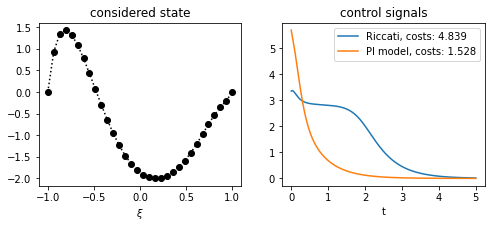

In [11]:
# 1
analysis_on_single_state(xi, dataset['X0'][0])

feedback set: <function InfiniteHorizon.feedback_from_value.<locals>.feedback at 0x000001CB9851FCA0>
integrating system dynamics with assigned feedback control, done in 123.27103638648987 s
Kosten:  0.69481087
feedback set: [[0.06473397 0.12967229 0.13028686 0.13131617 0.1327679  0.13465281
  0.13698494 0.1397817  0.14306405 0.14685668 0.15118825 0.15474904
  0.15756597 0.15966034 0.1610479  0.16173908 0.16173908 0.1610479
  0.15966034 0.15756597 0.15474904 0.15118825 0.14685668 0.14306405
  0.1397817  0.13698494 0.13465281 0.1327679  0.13131617 0.13028686
  0.12967229 0.06473397]]
integrating system dynamics with assigned feedback control, done in 8.34038257598877 s
Kosten:  0.7119731


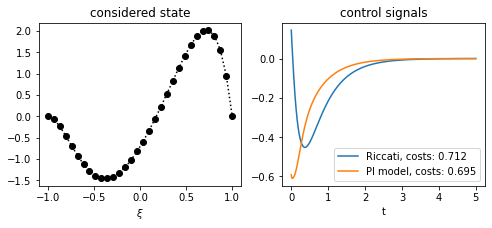

In [12]:
# 2
analysis_on_single_state(xi, (xi-1)*(xi+1)/1000*(-2749*xi**4 - 905*xi**3 - 2463*xi**2 - 3570*xi + 712))